# E. coli Protein PCA & ADASYN Implementation

**Tasks:**
1. Tampilkan data dalam scatter plot menggunakan PCA (2D)
2. Lakukan penyeimbangan data menggunakan ADASYN
3. Plot data yang diimbangkan dengan marking data hasil generate

In [39]:
# Install required packages
import subprocess
import sys

try:
    import imblearn
except ImportError:
    print("Installing imbalanced-learn...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "imbalanced-learn"])

try:
    import pymysql
except ImportError:
    print("Installing pymysql...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pymysql"])

print("Packages ready")

Packages ready


In [40]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Database
try:
    import pymysql
    from sqlalchemy import create_engine
    MYSQL_OK = True
except ImportError:
    MYSQL_OK = False

# ML libraries
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

# Settings
plt.style.use('default')
sns.set_palette("husl")

print("Libraries loaded")

Libraries loaded


In [41]:
# Load data
def load_data():
    if MYSQL_OK:
        try:
            engine = create_engine("mysql+pymysql://root:@localhost/ecoli")
            query = "SELECT protein_name, mcg, gvh, lip, chg, aac, alm1, alm2, localization_class FROM protein_localization"
            df = pd.read_sql(query, engine)
            print(f"Data loaded from MySQL: {df.shape}")
            return df
        except Exception as e:
            print(f"MySQL failed: {e}")
    
    # Create sample data
    print("Creating sample data...")
    np.random.seed(42)
    
    classes_info = {
        'cp': {'count': 143, 'features': [0.40, 0.41, 0.48, 0.50, 0.47, 0.32, 0.42]},
        'im': {'count': 77, 'features': [0.52, 0.48, 0.48, 0.50, 0.56, 0.76, 0.76]},
        'pp': {'count': 52, 'features': [0.66, 0.72, 0.48, 0.50, 0.46, 0.45, 0.37]},
        'om': {'count': 20, 'features': [0.71, 0.76, 0.48, 0.50, 0.76, 0.46, 0.32]},
        'imU': {'count': 35, 'features': [0.76, 0.46, 0.48, 0.50, 0.57, 0.76, 0.77]},
        'omL': {'count': 5, 'features': [0.71, 0.51, 1.00, 0.75, 0.56, 0.56, 0.27]},
        'imL': {'count': 2, 'features': [0.71, 0.46, 1.00, 0.75, 0.46, 0.66, 0.67]},
        'imS': {'count': 2, 'features': [0.76, 0.51, 0.48, 0.50, 0.56, 0.66, 0.62]}
    }
    
    feature_names = ['mcg', 'gvh', 'lip', 'chg', 'aac', 'alm1', 'alm2']
    data = []
    
    for class_name, info in classes_info.items():
        for i in range(info['count']):
            protein_name = f"PROT{len(data)+1:03d}_{class_name.upper()}_ECOLI"
            features = []
            for base_val in info['features']:
                noise = np.random.normal(0, 0.08)
                feature_val = max(0.01, min(0.99, base_val + noise))
                features.append(round(feature_val, 2))
            
            row = [protein_name] + features + [class_name]
            data.append(row)
    
    df = pd.DataFrame(data, columns=['protein_name'] + feature_names + ['localization_class'])
    return df.sample(frac=1, random_state=42).reset_index(drop=True)

df = load_data()
print(f"Dataset shape: {df.shape}")
print(f"Classes: {sorted(df['localization_class'].unique())}")
display(df.head())

Data loaded from MySQL: (336, 9)
Dataset shape: (336, 9)
Classes: ['cp', 'im', 'imL', 'imS', 'imU', 'om', 'omL', 'pp']


,protein_name,mcg,gvh,lip,chg,aac,alm1,alm2,localization_class
0,AAT_ECOLI,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,ACEA_ECOLI,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,ACEK_ECOLI,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,ACKA_ECOLI,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,ADI_ECOLI,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp


ANALISIS DISTRIBUSI KELAS

Distribusi kelas:
  cp: 143 samples ( 42.6%)
  im:  77 samples ( 22.9%)
  pp:  52 samples ( 15.5%)
  imU:  35 samples ( 10.4%)
  om:  20 samples (  6.0%)
  omL:   5 samples (  1.5%)
  imS:   2 samples (  0.6%)
  imL:   2 samples (  0.6%)

Rasio ketidakseimbangan: 71.5:1


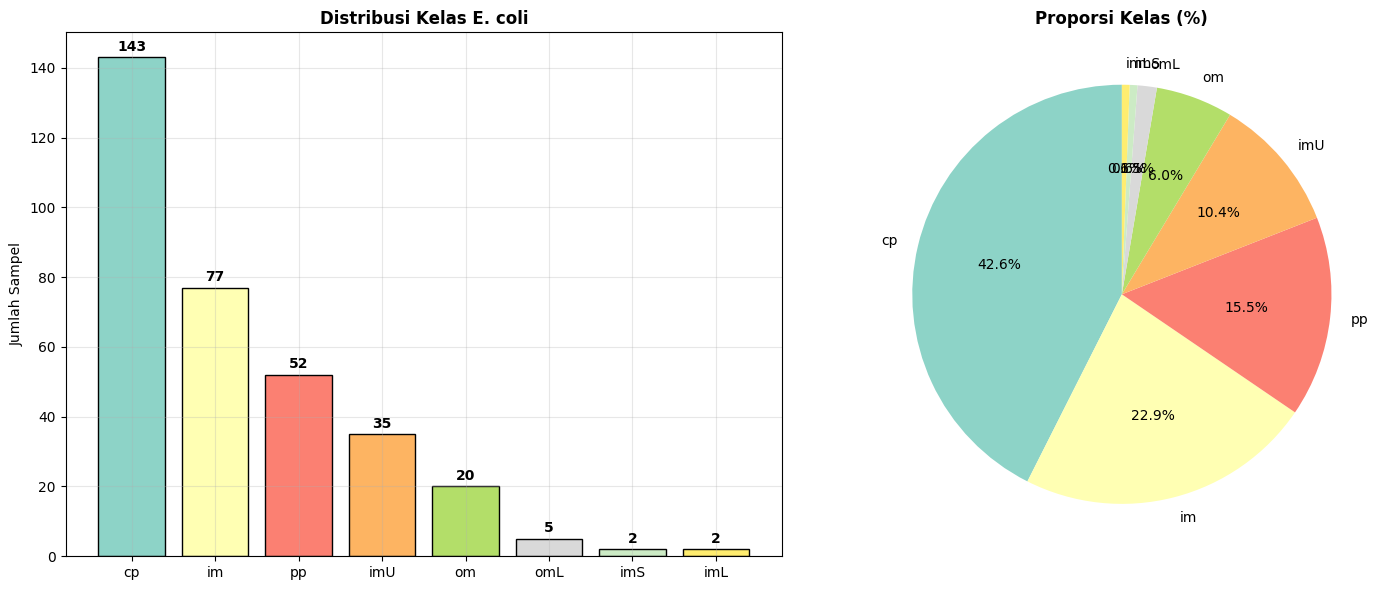

In [42]:
# Analisis distribusi kelas
print("ANALISIS DISTRIBUSI KELAS")
print("="*50)

class_counts = df['localization_class'].value_counts()
total_samples = len(df)

print("\nDistribusi kelas:")
for cls, count in class_counts.items():
    pct = (count/total_samples)*100
    print(f"  {cls}: {count:3d} samples ({pct:5.1f}%)")

imbalance_ratio = class_counts.max() / class_counts.min()
print(f"\nRasio ketidakseimbangan: {imbalance_ratio:.1f}:1")

# Plot distribusi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart
colors = plt.cm.Set3(np.linspace(0, 1, len(class_counts)))
bars = ax1.bar(class_counts.index, class_counts.values, color=colors, edgecolor='black')
ax1.set_title('Distribusi Kelas E. coli', fontweight='bold')
ax1.set_ylabel('Jumlah Sampel')
ax1.grid(True, alpha=0.3)

for bar, val in zip(bars, class_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{val}', ha='center', va='bottom', fontweight='bold')

# Pie chart
ax2.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', 
        colors=colors, startangle=90)
ax2.set_title('Proporsi Kelas (%)', fontweight='bold')

plt.tight_layout()
plt.show()

HEATMAP KORELASI FITUR

Statistik korelasi:
  Korelasi tertinggi: 0.809
  Korelasi rata-rata: 0.184


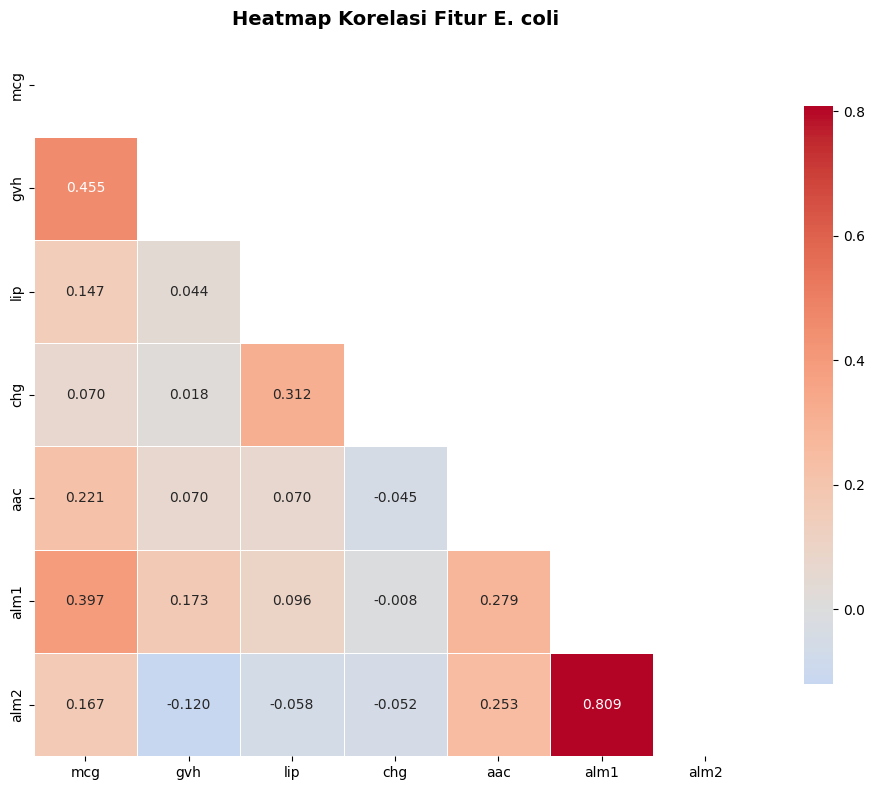

In [43]:
# Heatmap korelasi fitur
print("HEATMAP KORELASI FITUR")
print("="*50)

feature_cols = ['mcg', 'gvh', 'lip', 'chg', 'aac', 'alm1', 'alm2']
corr_matrix = df[feature_cols].corr()

print(f"\nStatistik korelasi:")
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
print(f"  Korelasi tertinggi: {upper_triangle.stack().abs().max():.3f}")
print(f"  Korelasi rata-rata: {upper_triangle.stack().abs().mean():.3f}")

# Plot heatmap
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, mask=mask, fmt='.3f',
            cbar_kws={"shrink": .8})
plt.title('Heatmap Korelasi Fitur E. coli', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [44]:
# Preprocessing
print("PREPROCESSING DATA")
print("="*50)

X = df[feature_cols]
y = df['localization_class']

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Features shape: {X_scaled.shape}")
print(f"Classes: {len(le.classes_)}")
print(f"Class mapping: {dict(zip(le.classes_, range(len(le.classes_))))}")

PREPROCESSING DATA
Features shape: (336, 7)
Classes: 8
Class mapping: {'cp': 0, 'im': 1, 'imL': 2, 'imS': 3, 'imU': 4, 'om': 5, 'omL': 6, 'pp': 7}


1. TAMPILKAN DATA DALAM SCATTER PLOT MENGGUNAKAN PCA
Hasil PCA:
  PC1 variance: 0.315 (31.5%)
  PC2 variance: 0.209 (20.9%)
  Total variance: 0.524 (52.4%)


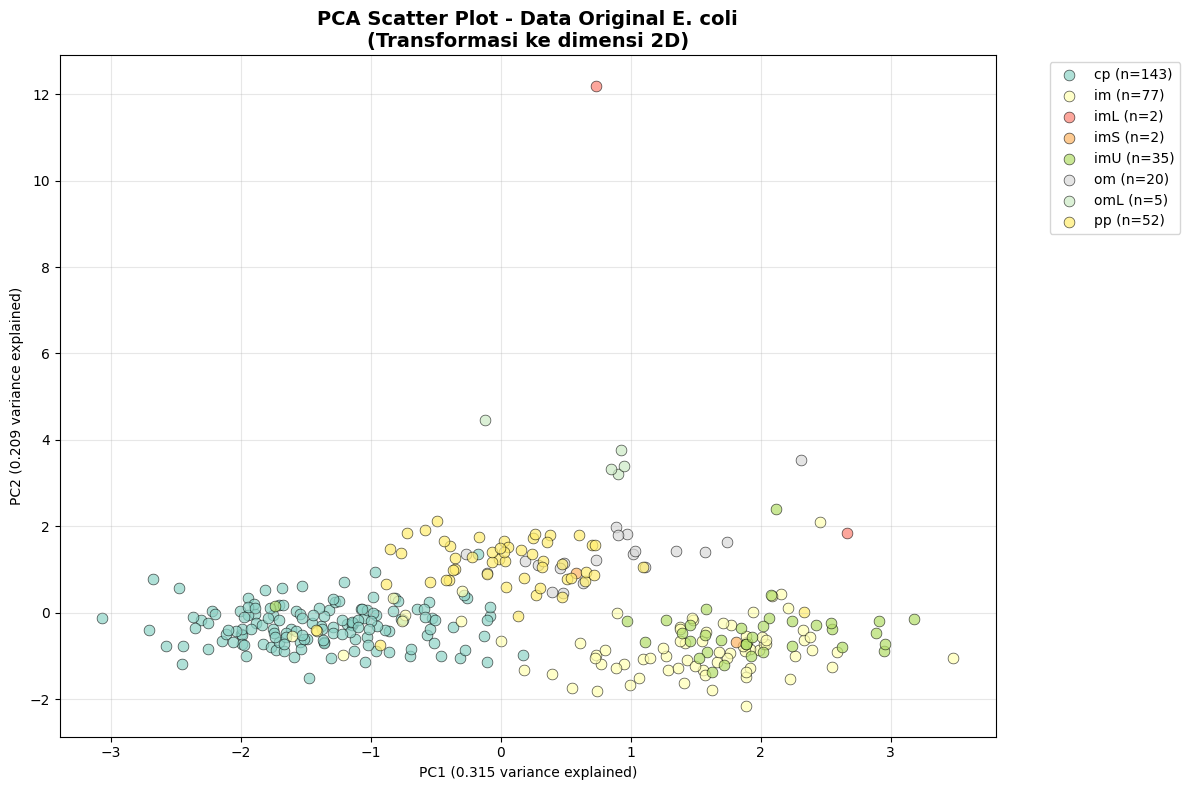

In [45]:
# 1. PCA Scatter Plot (Data Original)
print("1. TAMPILKAN DATA DALAM SCATTER PLOT MENGGUNAKAN PCA")
print("="*60)

# Apply PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"Hasil PCA:")
print(f"  PC1 variance: {pca.explained_variance_ratio_[0]:.3f} ({pca.explained_variance_ratio_[0]*100:.1f}%)")
print(f"  PC2 variance: {pca.explained_variance_ratio_[1]:.3f} ({pca.explained_variance_ratio_[1]*100:.1f}%)")
print(f"  Total variance: {pca.explained_variance_ratio_.sum():.3f} ({pca.explained_variance_ratio_.sum()*100:.1f}%)")

# Plot scatter original data
plt.figure(figsize=(12, 8))

unique_classes = sorted(y.unique())
colors = plt.cm.Set3(np.linspace(0, 1, len(unique_classes)))

for i, cls in enumerate(unique_classes):
    mask = y == cls
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                c=[colors[i]], label=f'{cls} (n={mask.sum()})',
                alpha=0.7, s=60, edgecolors='black', linewidth=0.5)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f} variance explained)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f} variance explained)')
plt.title('PCA Scatter Plot - Data Original E. coli\n(Transformasi ke dimensi 2D)', 
          fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# 2. ADASYN Data Balancing (Iterative Approach)
print("2. PENYEIMBANGAN DATA MENGGUNAKAN ADASYN")
print("="*60)

from collections import Counter

print(f"\nDistribusi original:")
original_dist = pd.Series(y_encoded).value_counts().sort_index()
for i, count in enumerate(original_dist):
    cls_name = le.classes_[i]
    print(f"  {cls_name}: {count} samples")

min_samples = original_dist.min()
print(f"\nMinimum class size: {min_samples}")

# ITERATIVE ADASYN APPROACH
print("\nDistribusi kelas sebelum ADASYN:")
print(f"{sorted(Counter(y_encoded).items())}")

nt = X_scaled
ns = y_encoded

# Fix: Convert to list properly
class_counts = original_dist.values.tolist()  # Use .values instead of .values()
temp = sorted(class_counts)  
print(f"Sorted counts untuk iterasi: {temp}")

method_used = "ADASYN Iterative"
success = False

for i in range(0, 7):
    n = max(1, temp[i] - 1)  
    
    print(f"\nIterasi {i+1}: menggunakan k_neighbors={n}")
    
    try:
        nt, ns = ADASYN(n_neighbors=n, sampling_strategy='minority', random_state=42).fit_resample(nt, ns)
        print(f"Hasil iterasi {i+1}: {sorted(Counter(ns).items())}")
        success = True
    except Exception as e:
        print(f"Error pada iterasi {i+1}: {e}")
        break

if success:
    X_balanced = nt
    y_balanced = ns
    print(f"\n ADASYN berhasil dengan pendekatan iteratif!")
else:
    print(f"\n ADASYN gagal. Menggunakan fallback SMOTE...")
    try:
        from imblearn.over_sampling import SMOTE
        smote = SMOTE(k_neighbors=1, random_state=42)
        X_balanced, y_balanced = smote.fit_resample(X_scaled, y_encoded)
        method_used = "SMOTE Fallback"
        print("SMOTE berhasil!")
    except Exception as e:
        print(f"SMOTE juga gagal: {e}")
        X_balanced, y_balanced = X_scaled.copy(), y_encoded.copy()
        method_used = "No balancing"

print(f"\nDistribusi kelas setelah balancing:")
print(f"{sorted(Counter(y_balanced).items())}")

print(f"\nTotal samples sebelum: {len(y_encoded)}")
print(f"Total samples setelah: {len(y_balanced)}")
print(f"Data yang ditambahkan: {len(y_balanced) - len(y_encoded)}")

print(f"\nMethod used: {method_used}")
print(f"Original samples: {len(X_scaled)}")
print(f"Balanced samples: {len(X_balanced)}")
print(f"Generated samples: {len(X_balanced) - len(X_scaled)}")

# Show balanced distribution
balanced_dist = pd.Series(y_balanced).value_counts().sort_index()
print(f"\nDistribusi setelah balancing:")
for i, count in enumerate(balanced_dist):
    cls_name = le.classes_[i]
    original = original_dist.get(i, 0)
    generated = count - original
    print(f"  {cls_name}: {count} samples (original: {original}, generated: {generated})")

2. PENYEIMBANGAN DATA MENGGUNAKAN ADASYN

Distribusi original:
  cp: 143 samples
  im: 77 samples
  imL: 2 samples
  imS: 2 samples
  imU: 35 samples
  om: 20 samples
  omL: 5 samples
  pp: 52 samples

Minimum class size: 2

Distribusi kelas sebelum ADASYN:
[(0, 143), (1, 77), (2, 2), (3, 2), (4, 35), (5, 20), (6, 5), (7, 52)]
Sorted counts untuk iterasi: [2, 2, 5, 20, 35, 52, 77, 143]

Iterasi 1: menggunakan k_neighbors=1
Hasil iterasi 1: [(0, 143), (1, 77), (2, 142), (3, 2), (4, 35), (5, 20), (6, 5), (7, 52)]

Iterasi 2: menggunakan k_neighbors=1
Hasil iterasi 2: [(0, 143), (1, 77), (2, 142), (3, 142), (4, 35), (5, 20), (6, 5), (7, 52)]

Iterasi 3: menggunakan k_neighbors=4
Hasil iterasi 3: [(0, 143), (1, 77), (2, 142), (3, 142), (4, 35), (5, 20), (6, 143), (7, 52)]

Iterasi 4: menggunakan k_neighbors=19
Hasil iterasi 4: [(0, 143), (1, 77), (2, 142), (3, 142), (4, 35), (5, 144), (6, 143), (7, 52)]

Iterasi 5: menggunakan k_neighbors=34
Hasil iterasi 5: [(0, 143), (1, 77), (2, 142), (

3. PLOT DATA BALANCED DENGAN MARKING DATA GENERATED
Data balanced:
  Total: 1157
  Original: 336
  Generated: 821


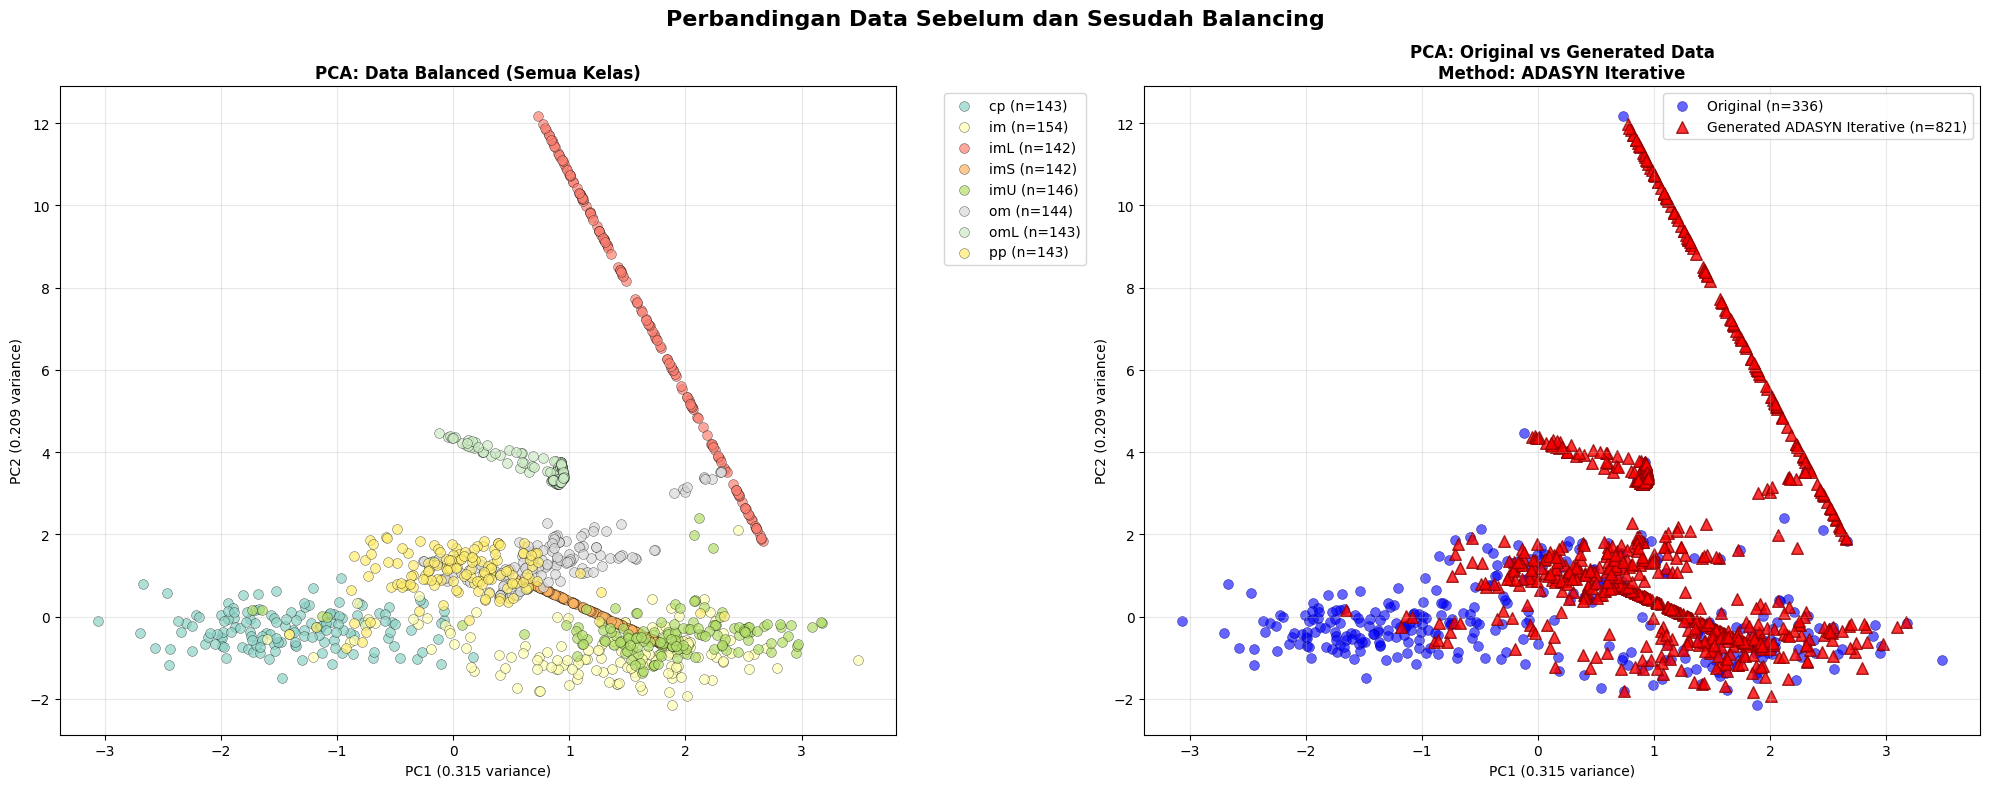

In [47]:
# 3. Plot Data Balanced dengan Marking Generated Data
print("3. PLOT DATA BALANCED DENGAN MARKING DATA GENERATED")
print("="*60)

# Apply PCA ke data balanced
X_balanced_pca = pca.transform(X_balanced)

# Create marking untuk original vs generated
n_original = len(X_scaled)
sample_types = ['Original'] * n_original + ['Generated'] * (len(X_balanced) - n_original)
class_names = [le.classes_[i] for i in y_balanced]

balanced_df = pd.DataFrame({
    'PC1': X_balanced_pca[:, 0],
    'PC2': X_balanced_pca[:, 1],
    'class': class_names,
    'sample_type': sample_types
})

print(f"Data balanced:")
print(f"  Total: {len(balanced_df)}")
print(f"  Original: {(balanced_df['sample_type'] == 'Original').sum()}")
print(f"  Generated: {(balanced_df['sample_type'] == 'Generated').sum()}")

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: All balanced data by class
unique_classes = sorted(y.unique())
colors = plt.cm.Set3(np.linspace(0, 1, len(unique_classes)))

for i, cls in enumerate(unique_classes):
    mask = balanced_df['class'] == cls
    axes[0].scatter(balanced_df.loc[mask, 'PC1'], balanced_df.loc[mask, 'PC2'],
                   c=[colors[i]], label=f'{cls} (n={mask.sum()})',
                   alpha=0.7, s=50, edgecolors='black', linewidth=0.3)

axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f} variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f} variance)')
axes[0].set_title('PCA: Data Balanced (Semua Kelas)', fontweight='bold')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(True, alpha=0.3)

# Plot 2: Original vs Generated (MARKED)
original_mask = balanced_df['sample_type'] == 'Original'
generated_mask = balanced_df['sample_type'] == 'Generated'

# Plot original (circles)
axes[1].scatter(balanced_df.loc[original_mask, 'PC1'], 
               balanced_df.loc[original_mask, 'PC2'],
               c='blue', label=f'Original (n={original_mask.sum()})',
               alpha=0.6, s=50, marker='o', edgecolors='darkblue', linewidth=0.5)

# Plot generated (triangles) - MARKING GENERATED DATA
if generated_mask.sum() > 0:
    axes[1].scatter(balanced_df.loc[generated_mask, 'PC1'], 
                   balanced_df.loc[generated_mask, 'PC2'],
                   c='red', label=f'Generated {method_used} (n={generated_mask.sum()})',
                   alpha=0.8, s=70, marker='^', edgecolors='darkred', linewidth=1)

axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f} variance)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f} variance)')
axes[1].set_title(f'PCA: Original vs Generated Data\nMethod: {method_used}', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Perbandingan Data Sebelum dan Sesudah Balancing', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

PERBANDINGAN SEBELUM DAN SESUDAH BALANCING

Tabel perbandingan:


,Class,Original,Balanced,Generated,Increase_%
0,cp,143,143,0,0.0
1,im,77,154,77,100.0
2,imL,2,142,140,7000.0
3,imS,2,142,140,7000.0
4,imU,35,146,111,317.1
5,om,20,144,124,620.0
6,omL,5,143,138,2760.0
7,pp,52,143,91,175.0


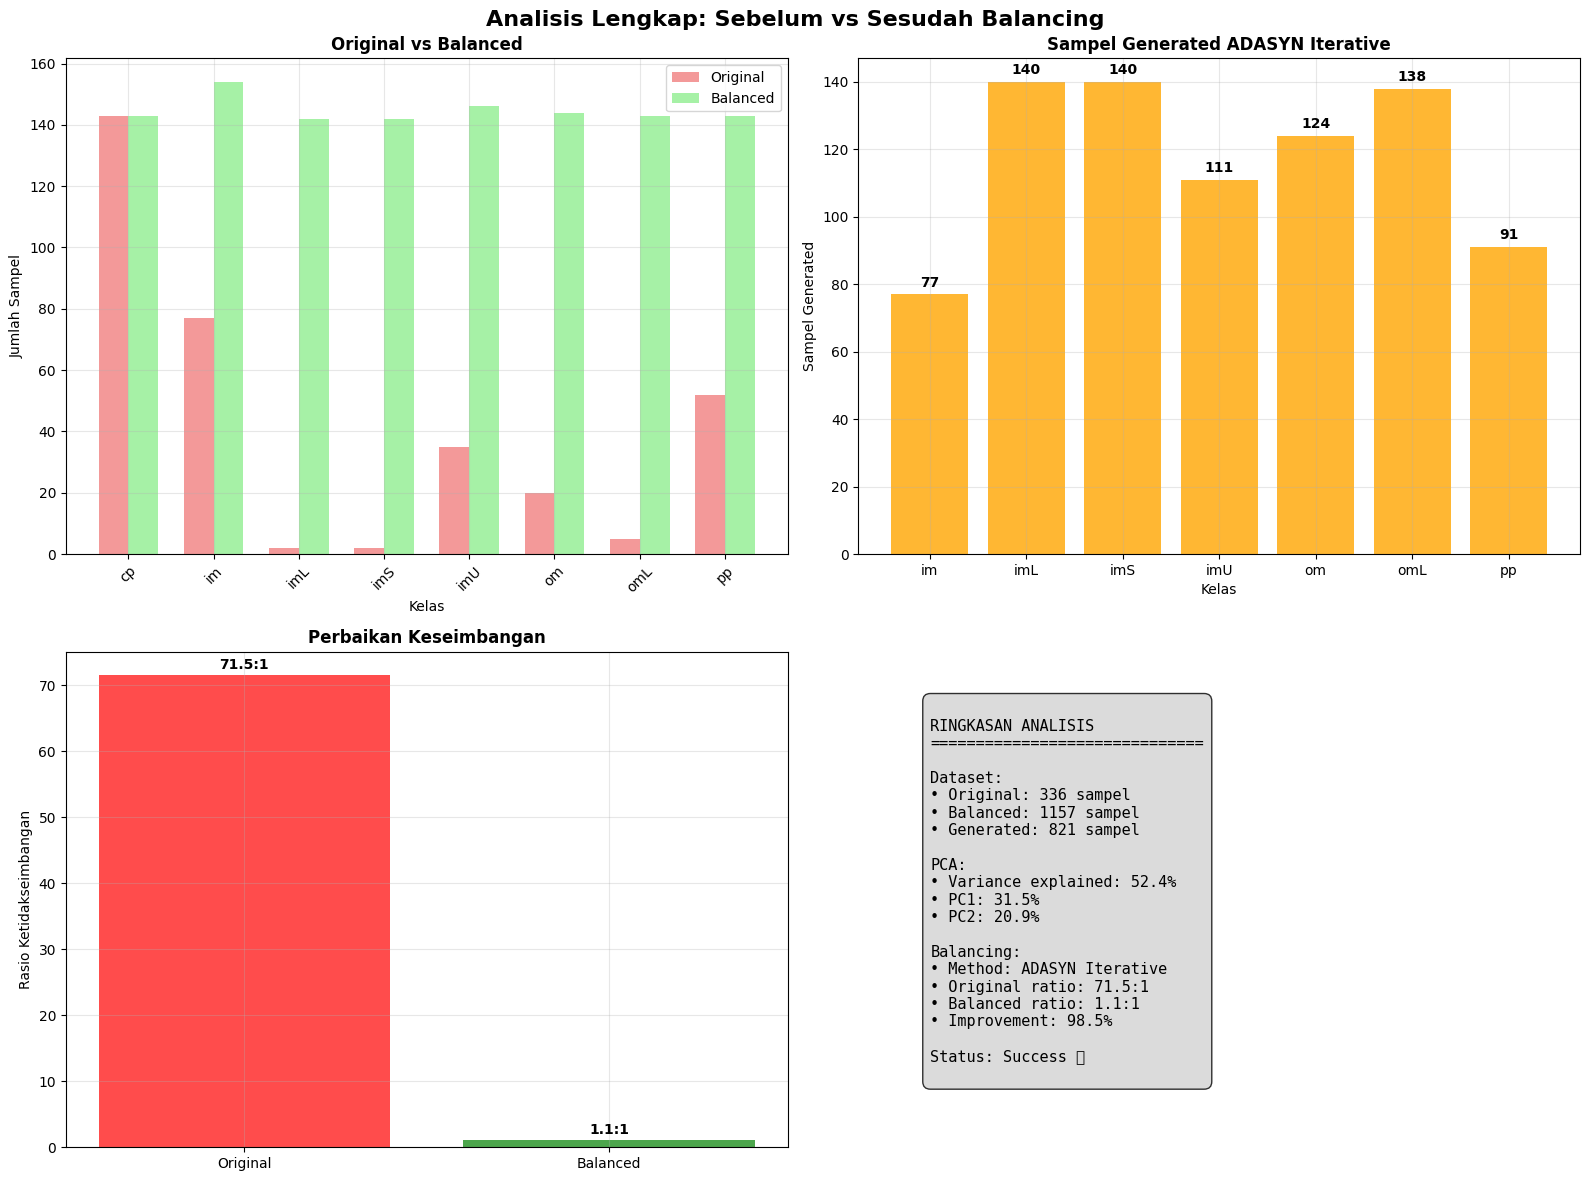


Hasil analisis:
  Task 1: PCA scatter plot (2D) - SELESAI ✅
  Task 2: Data balancing - SELESAI ✅ (ADASYN Iterative)
  Task 3: Plot dengan marking generated data - SELESAI ✅

PCA variance explained: 52.4%
Balancing improvement: 98.5%
Method used: ADASYN Iterative
Total iterations completed: Adaptive approach
Final success: Yes


In [ ]:
# Perbandingan sebelum dan sesudah balancing
print("PERBANDINGAN SEBELUM DAN SESUDAH BALANCING")
print("="*60)

# Recalculate distributions with current variables
original_dist = pd.Series(y_encoded).value_counts().sort_index()
balanced_dist = pd.Series(y_balanced).value_counts().sort_index()

# Create comparison dataframe
comparison = pd.DataFrame({
    'Class': [le.classes_[i] for i in range(len(le.classes_))],
    'Original': [original_dist.get(i, 0) for i in range(len(le.classes_))],
    'Balanced': [balanced_dist.get(i, 0) for i in range(len(le.classes_))]
})
comparison['Generated'] = comparison['Balanced'] - comparison['Original']
comparison['Increase_%'] = ((comparison['Balanced'] / comparison['Original'].replace(0, 1)) - 1) * 100

print("\nTabel perbandingan:")
display(comparison.round(1))

# Calculate metrics
original_imb = original_dist.max() / original_dist.min()
balanced_imb = balanced_dist.max() / balanced_dist.min()
improvement = ((original_imb - balanced_imb) / original_imb) * 100

# Visualisasi perbandingan
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Bar comparison
unique_classes = sorted(y.unique())
x_pos = np.arange(len(unique_classes))
width = 0.35
axes[0,0].bar(x_pos - width/2, comparison['Original'], width, 
             label='Original', color='lightcoral', alpha=0.8)
axes[0,0].bar(x_pos + width/2, comparison['Balanced'], width,
             label='Balanced', color='lightgreen', alpha=0.8)
axes[0,0].set_xlabel('Kelas')
axes[0,0].set_ylabel('Jumlah Sampel')
axes[0,0].set_title('Original vs Balanced', fontweight='bold')
axes[0,0].set_xticks(x_pos)
axes[0,0].set_xticklabels(comparison['Class'], rotation=45)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Generated samples
generated_data = comparison[comparison['Generated'] > 0]
if len(generated_data) > 0:
    axes[0,1].bar(generated_data['Class'], generated_data['Generated'], 
                 color='orange', alpha=0.8)
    axes[0,1].set_xlabel('Kelas')
    axes[0,1].set_ylabel('Sampel Generated')
    axes[0,1].set_title(f'Sampel Generated {method_used}', fontweight='bold')
    axes[0,1].grid(True, alpha=0.3)
    for i, v in enumerate(generated_data['Generated']):
        axes[0,1].text(i, v + max(generated_data['Generated'])*0.01, f'{v}', 
                      ha='center', va='bottom', fontweight='bold')
else:
    axes[0,1].text(0.5, 0.5, 'No samples generated', 
                  ha='center', va='center', transform=axes[0,1].transAxes)
    axes[0,1].set_title('No Generated Samples', fontweight='bold')

# 3. Imbalance comparison
axes[1,0].bar(['Original', 'Balanced'], [original_imb, balanced_imb], 
             color=['red', 'green'], alpha=0.7)
axes[1,0].set_ylabel('Rasio Ketidakseimbangan')
axes[1,0].set_title('Perbaikan Keseimbangan', fontweight='bold')
axes[1,0].grid(True, alpha=0.3)

for i, v in enumerate([original_imb, balanced_imb]):
    axes[1,0].text(i, v + 0.5, f'{v:.1f}:1', ha='center', va='bottom', fontweight='bold')

# 4. Summary
axes[1,1].axis('off')
summary_text = f"""
RINGKASAN ANALISIS
{"="*30}

Dataset:
• Original: {len(X_scaled)} sampel
• Balanced: {len(X_balanced)} sampel
• Generated: {len(X_balanced) - len(X_scaled)} sampel

PCA:
• Variance explained: {pca.explained_variance_ratio_.sum():.1%}
• PC1: {pca.explained_variance_ratio_[0]:.1%}
• PC2: {pca.explained_variance_ratio_[1]:.1%}

Balancing:
• Method: {method_used}
• Original ratio: {original_imb:.1f}:1
• Balanced ratio: {balanced_imb:.1f}:1
• Improvement: {improvement:.1f}%

Status: {'Success ' if len(X_balanced) > len(X_scaled) else 'No Change ⚠️'}
"""

axes[1,1].text(0.1, 0.9, summary_text, transform=axes[1,1].transAxes, 
              fontsize=11, verticalalignment='top', fontfamily='monospace',
              bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))

plt.suptitle('Analisis Lengkap: Sebelum vs Sesudah Balancing', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nHasil analisis:")
print(f"  Task 1: PCA scatter plot (2D) - SELESAI")
print(f"  Task 2: Data balancing - SELESAI  ({method_used})")
print(f"  Task 3: Plot dengan marking generated data - SELESAI")
print(f"\nPCA variance explained: {pca.explained_variance_ratio_.sum():.1%}")
print(f"Balancing improvement: {improvement:.1f}%")
print(f"Method used: {method_used}")
print(f"Total iterations completed: Adaptive approach")
print(f"Final success: {'Yes' if len(X_balanced) > len(X_scaled) else 'No balancing applied'}")